# CNN 101


In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import time

tf.keras.backend.set_floatx('float32')

EPOCHS=200
SPLITS=1
K=1
EMBED_DIMEN=16
FILENAME='CNN101'

## Load and partition sequences

In [2]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def make_slice(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


In [3]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1:
            kmer=seq[i:i+K]
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [4]:
def build_model(maxlen,dimen):
    vocabulary_size=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
    act="sigmoid"
    dt='float32'

    neurons=32
    rnn = keras.models.Sequential()
    conv1_layer = keras.layers.Conv1D(filters=64,kernel_size=3,
                activation="relu",padding="valid",input_shape=[maxlen,vocabulary_size])
    pool1_layer = keras.layers.MaxPooling1D(2)
    conv2_layer = keras.layers.Conv1D(neurons,3,activation="relu",padding="same")
    conv3_layer = keras.layers.Conv1D(neurons,3,activation="relu",padding="same")
    pool2_layer = keras.layers.MaxPooling1D(2)
    conv4_layer = keras.layers.Conv1D(neurons,3,activation="relu",padding="same")
    conv5_layer = keras.layers.Conv1D(neurons,3,activation="relu",padding="same")
    flat1_layer = keras.layers.Flatten()
    dense1_layer = keras.layers.Dense(neurons,activation=act,dtype=dt)
    drop1_layer = keras.layers.Dropout(0.5)
    dense2_layer = keras.layers.Dense(neurons,activation=act,dtype=dt)
    drop2_layer = keras.layers.Dropout(0.5)
    output_layer = keras.layers.Dense(1,activation=act,dtype=dt)

    rnn.add(conv1_layer)
    #rnn.add(pool1_layer)
    rnn.add(conv2_layer)
    #rnn.add(conv3_layer)
    rnn.add(pool2_layer)
    rnn.add(conv4_layer)
    rnn.add(conv5_layer)
    rnn.add(flat1_layer)
    rnn.add(dense1_layer)
    rnn.add(drop1_layer)
    rnn.add(dense2_layer)
    rnn.add(drop2_layer)
    rnn.add(output_layer)

    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    opt=tf.keras.optimizers.Adam(learning_rate=0.01)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer=opt,metrics=["accuracy"])
    return rnn

In [5]:
def do_cross_validation(X,y,eps,maxlen,dimen):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    rnn2=None
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]

        print("BUILD MODEL")
        rnn2=build_model(maxlen,dimen)

        print("FIT")
        start_time=time.time()
        history=rnn2.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)
                        
        fold += 1
        print("Fold %d, %d epochs, %d sec"%(fold,eps,elapsed_time))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = rnn2.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return rnn2

In [6]:
def make_kmers(MINLEN,MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    #print(type(X_train_all))
    #print(X_train_all.shape)
    #print(X_train_all.iloc[0])
    #print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    #print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    #print(type(X_train_kmers))
    #print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
print("Load data from files.")
nc_seq=load_fasta('ncRNA.fasta',0)
pc_seq=load_fasta('pcRNA.fasta',1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

print("Put aside the test portion.")
(train_set,test_set)=make_train_test(all_seq)
# Do this later when using the test data:
# (X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

print("Ready: train_set")
train_set

Load data from files.
Put aside the test portion.
Ready: train_set


,seqnum,class,sequence,seqlen
1280,1281,0,AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...,348
9088,9089,0,CAGCTCCTGGGATGGCCTCACCTGAGGAGACTCTTGGGCCTTGGCA...,534
6069,6070,1,AGATCTAGGGATGGGGATGGGGAGGAGAAGTGGGAATGGGAAATTG...,592
18549,18550,1,GACGTCTCCCGCGGGCGTCGGCAGGGTCGGCGGCGTCGGCAGCAGT...,945
15027,15028,1,GAGCGCGCGAGCCGGGCCCGGAGCGCACGCCGCCGCCGCCACCGCC...,4382
...,...,...,...,...
3386,3387,0,TTTATGTGGATTGTCTGTCTCATGCTTGTTTCACCAGGGTAGTTAC...,578
6495,6496,0,ATAATGGGAAACTAAGGGCAAGTTCTCATGTTCCTGGTCCTGGCTT...,562
6409,6410,1,GGGTTTATTACTACTGAAGGAAGAACGTGAGTAGGTTAGGATTTCG...,740
7640,7641,1,ACAGCTGTGTTTGGCTGCAGGGCCAAGAGCGCTGTCAAGAAGACCC...,3156


In [8]:
def onehot(seqs):
    newX = []
    vectors=[]
    vectors.append([0,0,0,0,1])
    vectors.append([1,0,0,0,0])
    vectors.append([0,1,0,0,0])
    vectors.append([0,0,1,0,0])
    vectors.append([0,0,0,1,0])
    for seq in X_train:
        letters=[]
        for num in seq:
            hot = vectors[num]
            letters.append(hot)
        newX.append(letters)
    return np.asarray(newX)

## Len 200-1Kb


Working on full training set, slice by sequence length.
Slice size range [200 - 1000)
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
Sequence to Kmer
transform...
Length of list:
8879
Length of first element:
1000
First element:
[[1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
Compile the model
COMPILE
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 998, 64)           1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 998, 32)           6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 499, 32)           3104      
__________________________

222/222 [==============================] - 21s 95ms/step - loss: 0.6936 - accuracy: 0.5046 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 43/200
222/222 [==============================] - 21s 95ms/step - loss: 0.6933 - accuracy: 0.5064 - val_loss: 0.6933 - val_accuracy: 0.5011
Epoch 44/200
222/222 [==============================] - 21s 94ms/step - loss: 0.6934 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 45/200
222/222 [==============================] - 21s 93ms/step - loss: 0.6935 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 46/200
222/222 [==============================] - 21s 94ms/step - loss: 0.6934 - accuracy: 0.4995 - val_loss: 0.6935 - val_accuracy: 0.5011
Epoch 47/200
222/222 [==============================] - 21s 96ms/step - loss: 0.6934 - accuracy: 0.5036 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 48/200
222/222 [==============================] - 21s 96ms/step - loss: 0.6933 - accuracy: 0.4977 - val_loss: 0.6942 - val_accuracy

Epoch 98/200
222/222 [==============================] - 23s 104ms/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6936 - val_accuracy: 0.5011
Epoch 99/200
222/222 [==============================] - 23s 105ms/step - loss: 0.6936 - accuracy: 0.4922 - val_loss: 0.6934 - val_accuracy: 0.5011
Epoch 100/200
222/222 [==============================] - 26s 115ms/step - loss: 0.6934 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 101/200
222/222 [==============================] - 26s 117ms/step - loss: 0.6934 - accuracy: 0.5053 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 102/200
222/222 [==============================] - 23s 102ms/step - loss: 0.6934 - accuracy: 0.5036 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 103/200
222/222 [==============================] - 23s 106ms/step - loss: 0.6934 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 104/200
222/222 [==============================] - 23s 105ms/step - loss: 0.6936 - accuracy: 0.5053 - val_lo

222/222 [==============================] - 27s 122ms/step - loss: 0.6934 - accuracy: 0.5074 - val_loss: 0.6937 - val_accuracy: 0.5011
Epoch 154/200
222/222 [==============================] - 21s 96ms/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 155/200
222/222 [==============================] - 21s 97ms/step - loss: 0.6933 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 156/200
222/222 [==============================] - 24s 108ms/step - loss: 0.6936 - accuracy: 0.5018 - val_loss: 0.6934 - val_accuracy: 0.5011
Epoch 157/200
222/222 [==============================] - 23s 102ms/step - loss: 0.6933 - accuracy: 0.5044 - val_loss: 0.6933 - val_accuracy: 0.5011
Epoch 158/200
222/222 [==============================] - 24s 108ms/step - loss: 0.6935 - accuracy: 0.4909 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 159/200
222/222 [==============================] - 23s 103ms/step - loss: 0.6935 - accuracy: 0.4984 - val_loss: 0.6932 - v

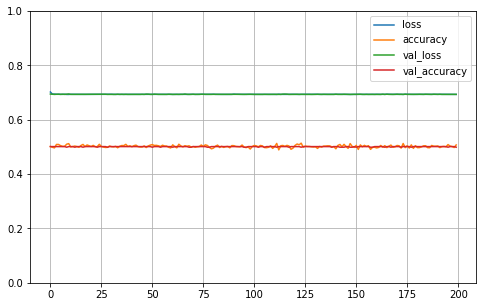

accuracy: 49.89%

Validation core mean 49.89% (+/- 0.00%)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: CNN101.short.model/assets


In [9]:
MINLEN=200
MAXLEN=1000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
X_train=onehot(X_train)
print("Length of list:")
print(len(X_train))
print("Length of first element:")
print(len(X_train[0]))
print("First element:")
print(X_train[0])
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model1=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)
model1.save(FILENAME+'.short.model')

## Len 1K-2Kb

Working on full training set, slice by sequence length.
Slice size range [1000 - 2000)
original (30290, 4)
no short (9273, 4)
no long, no short (3368, 4)
Sequence to Kmer
transform...
Compile the model
COMPILE
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 1998, 64)          1024      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1998, 32)          6176      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 999, 32)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 999, 32)           3104      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 999, 32)           3104      
__________________________________________

85/85 [==============================] - 17s 203ms/step - loss: 0.6637 - accuracy: 0.6221 - val_loss: 0.6716 - val_accuracy: 0.6039
Epoch 44/200
85/85 [==============================] - 17s 195ms/step - loss: 0.6633 - accuracy: 0.6221 - val_loss: 0.6726 - val_accuracy: 0.6039
Epoch 45/200
85/85 [==============================] - 17s 198ms/step - loss: 0.6637 - accuracy: 0.6221 - val_loss: 0.6723 - val_accuracy: 0.6039
Epoch 46/200
85/85 [==============================] - 16s 193ms/step - loss: 0.6635 - accuracy: 0.6221 - val_loss: 0.6725 - val_accuracy: 0.6039
Epoch 47/200
85/85 [==============================] - 17s 195ms/step - loss: 0.6630 - accuracy: 0.6221 - val_loss: 0.6718 - val_accuracy: 0.6039
Epoch 48/200
85/85 [==============================] - 17s 200ms/step - loss: 0.6629 - accuracy: 0.6221 - val_loss: 0.6724 - val_accuracy: 0.6039
Epoch 49/200
85/85 [==============================] - 17s 198ms/step - loss: 0.6640 - accuracy: 0.6221 - val_loss: 0.6721 - val_accuracy: 0.603

85/85 [==============================] - 18s 211ms/step - loss: 0.6636 - accuracy: 0.6221 - val_loss: 0.6721 - val_accuracy: 0.6039
Epoch 100/200
85/85 [==============================] - 17s 201ms/step - loss: 0.6633 - accuracy: 0.6221 - val_loss: 0.6726 - val_accuracy: 0.6039
Epoch 101/200
85/85 [==============================] - 20s 240ms/step - loss: 0.6632 - accuracy: 0.6221 - val_loss: 0.6720 - val_accuracy: 0.6039
Epoch 102/200
85/85 [==============================] - 23s 267ms/step - loss: 0.6634 - accuracy: 0.6225 - val_loss: 0.6719 - val_accuracy: 0.6039
Epoch 103/200
85/85 [==============================] - 19s 227ms/step - loss: 0.6637 - accuracy: 0.6221 - val_loss: 0.6719 - val_accuracy: 0.6039
Epoch 104/200
85/85 [==============================] - 23s 269ms/step - loss: 0.6634 - accuracy: 0.6221 - val_loss: 0.6725 - val_accuracy: 0.6039
Epoch 105/200
85/85 [==============================] - 18s 214ms/step - loss: 0.6633 - accuracy: 0.6221 - val_loss: 0.6724 - val_accuracy:

85/85 [==============================] - 22s 255ms/step - loss: 0.6635 - accuracy: 0.6221 - val_loss: 0.6729 - val_accuracy: 0.6039
Epoch 156/200
85/85 [==============================] - 20s 232ms/step - loss: 0.6632 - accuracy: 0.6221 - val_loss: 0.6721 - val_accuracy: 0.6039
Epoch 157/200
85/85 [==============================] - 17s 204ms/step - loss: 0.6634 - accuracy: 0.6221 - val_loss: 0.6718 - val_accuracy: 0.6039
Epoch 158/200
85/85 [==============================] - 21s 244ms/step - loss: 0.6633 - accuracy: 0.6221 - val_loss: 0.6724 - val_accuracy: 0.6039
Epoch 159/200
85/85 [==============================] - 20s 232ms/step - loss: 0.6635 - accuracy: 0.6221 - val_loss: 0.6720 - val_accuracy: 0.6039
Epoch 160/200
85/85 [==============================] - 22s 254ms/step - loss: 0.6635 - accuracy: 0.6221 - val_loss: 0.6720 - val_accuracy: 0.6039
Epoch 161/200
85/85 [==============================] - 21s 250ms/step - loss: 0.6632 - accuracy: 0.6221 - val_loss: 0.6722 - val_accuracy:

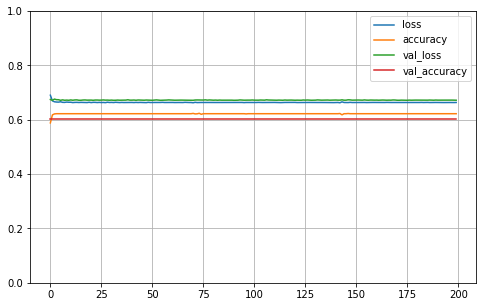

accuracy: 60.39%

Validation core mean 60.39% (+/- 0.00%)
INFO:tensorflow:Assets written to: CNN101.medium.model/assets


In [10]:
MINLEN=1000
MAXLEN=2000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
X_train=onehot(X_train)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model2=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)
model2.save(FILENAME+'.medium.model')

## Len 2K-3Kb

Working on full training set, slice by sequence length.
Slice size range [2000 - 3000)
original (30290, 4)
no short (3221, 4)
no long, no short (1351, 4)
Sequence to Kmer
transform...
Compile the model
COMPILE
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 2998, 64)          1024      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 2998, 32)          6176      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1499, 32)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 1499, 32)          3104      
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1499, 32)          3104      
__________________________________________

34/34 [==============================] - 8s 245ms/step - loss: 0.6045 - accuracy: 0.7083 - val_loss: 0.6297 - val_accuracy: 0.6790
Epoch 44/200
34/34 [==============================] - 9s 255ms/step - loss: 0.6044 - accuracy: 0.7083 - val_loss: 0.6299 - val_accuracy: 0.6790
Epoch 45/200
34/34 [==============================] - 9s 252ms/step - loss: 0.6037 - accuracy: 0.7083 - val_loss: 0.6296 - val_accuracy: 0.6790
Epoch 46/200
34/34 [==============================] - 10s 280ms/step - loss: 0.6032 - accuracy: 0.7083 - val_loss: 0.6302 - val_accuracy: 0.6790
Epoch 47/200
34/34 [==============================] - 9s 256ms/step - loss: 0.6041 - accuracy: 0.7083 - val_loss: 0.6290 - val_accuracy: 0.6790
Epoch 48/200
34/34 [==============================] - 9s 262ms/step - loss: 0.6041 - accuracy: 0.7083 - val_loss: 0.6292 - val_accuracy: 0.6790
Epoch 49/200
34/34 [==============================] - 9s 263ms/step - loss: 0.6042 - accuracy: 0.7083 - val_loss: 0.6295 - val_accuracy: 0.6790
Epoc

Epoch 100/200
34/34 [==============================] - 10s 297ms/step - loss: 0.6038 - accuracy: 0.7083 - val_loss: 0.6298 - val_accuracy: 0.6790
Epoch 101/200
34/34 [==============================] - 10s 301ms/step - loss: 0.6039 - accuracy: 0.7083 - val_loss: 0.6300 - val_accuracy: 0.6790
Epoch 102/200
34/34 [==============================] - 10s 282ms/step - loss: 0.6039 - accuracy: 0.7083 - val_loss: 0.6303 - val_accuracy: 0.6790
Epoch 103/200
34/34 [==============================] - 10s 283ms/step - loss: 0.6041 - accuracy: 0.7083 - val_loss: 0.6300 - val_accuracy: 0.6790
Epoch 104/200
34/34 [==============================] - 10s 285ms/step - loss: 0.6039 - accuracy: 0.7083 - val_loss: 0.6295 - val_accuracy: 0.6790
Epoch 105/200
34/34 [==============================] - 11s 328ms/step - loss: 0.6043 - accuracy: 0.7083 - val_loss: 0.6307 - val_accuracy: 0.6790
Epoch 106/200
34/34 [==============================] - 10s 294ms/step - loss: 0.6041 - accuracy: 0.7083 - val_loss: 0.6294 -

34/34 [==============================] - 9s 271ms/step - loss: 0.6036 - accuracy: 0.7083 - val_loss: 0.6299 - val_accuracy: 0.6790
Epoch 157/200
34/34 [==============================] - 9s 272ms/step - loss: 0.6039 - accuracy: 0.7083 - val_loss: 0.6301 - val_accuracy: 0.6790
Epoch 158/200
34/34 [==============================] - 9s 275ms/step - loss: 0.6043 - accuracy: 0.7083 - val_loss: 0.6291 - val_accuracy: 0.6790
Epoch 159/200
34/34 [==============================] - 9s 273ms/step - loss: 0.6038 - accuracy: 0.7083 - val_loss: 0.6296 - val_accuracy: 0.6790
Epoch 160/200
34/34 [==============================] - 9s 275ms/step - loss: 0.6040 - accuracy: 0.7083 - val_loss: 0.6303 - val_accuracy: 0.6790
Epoch 161/200
34/34 [==============================] - 9s 272ms/step - loss: 0.6042 - accuracy: 0.7083 - val_loss: 0.6297 - val_accuracy: 0.6790
Epoch 162/200
34/34 [==============================] - 10s 284ms/step - loss: 0.6042 - accuracy: 0.7083 - val_loss: 0.6301 - val_accuracy: 0.679

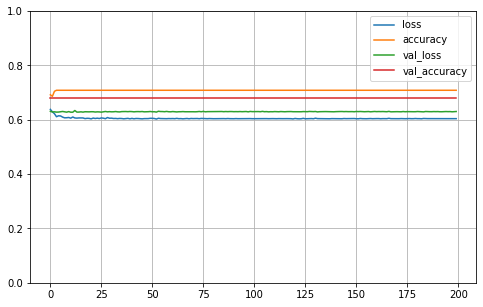

accuracy: 67.90%

Validation core mean 67.90% (+/- 0.00%)
INFO:tensorflow:Assets written to: CNN101.long.model/assets


In [11]:
MINLEN=2000
MAXLEN=3000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
X_train=onehot(X_train)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model3=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)
model3.save(FILENAME+'.long.model')